In [1]:
import altair as alt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
from scipy.stats import loguniform
import sklearn
from sklearn.compose import make_column_transformer
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
    accuracy_score, recall_score, precision_score,
    f1_score, precision_recall_curve, average_precision_score,
    classification_report, confusion_matrix,
    PrecisionRecallDisplay, roc_curve, roc_auc_score
)
from sklearn.model_selection import (
    cross_validate, RandomizedSearchCV
)
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import (
    StandardScaler, OneHotEncoder
)
from sklearn.model_selection import cross_val_predict

In [2]:
alt.renderers.enable('mimetype')

RendererRegistry.enable('mimetype')

In [3]:
#Reading the data
train_df = pd.read_csv("../data/processed/Heart_Failure_Data_train.csv")
test_df = pd.read_csv("../data/processed/Heart_Failure_Data_test.csv")

In [4]:
# Data splitting
X_train = train_df.drop("DEATH_EVENT", axis=1)
y_train = train_df['DEATH_EVENT']
X_test = test_df.drop("DEATH_EVENT", axis=1)
y_test = test_df['DEATH_EVENT']

In [5]:
# Seperate the features for preprocessing
numeric_features = ['age','creatinine_phosphokinase','ejection_fraction','platelets','serum_creatinine', 'serum_sodium','time']
binary_feats = ['sex', 'diabetes', 'high_blood_pressure','anaemia']

In [6]:
#define a column transformer
col_trans = make_column_transformer(
    (StandardScaler(), numeric_features),
    (OneHotEncoder(), binary_feats),

)

In [7]:
# Define the metrics
scoring = ['accuracy', 'precision', 'recall', 'f1']


Here we are using two classifiers for the initial performance calculation : 
1. KNeighborsClassifier
2. RandomForestClassifier

In [8]:
#Performance calculation
results = {}
pipe_knn = make_pipeline(
    col_trans,
    KNeighborsClassifier(n_neighbors=3)
)
results['KNeighborsClassifier'] = pd.DataFrame(cross_validate(pipe_knn, X_train,
                                        y_train, scoring=scoring)).mean()

pipe_rf = make_pipeline(
    col_trans,
    RandomForestClassifier(random_state=123)
)
results['RandomForestClassifier'] = pd.DataFrame(cross_validate(pipe_rf, X_train,
                                                y_train, scoring=scoring)).mean()

In [9]:
pd.DataFrame(results)

,KNeighborsClassifier,RandomForestClassifier
fit_time,0.014984,0.144800
score_time,0.013258,0.017895
test_accuracy,0.744858,0.828191
test_precision,0.646825,0.810152
test_recall,0.295238,0.577143
test_f1,0.401295,0.668142


We can observe that we arre getting better scores with RandomForestClassifier. To analyze further let's perform hyperparameter optimization on RandomForestClassifier.

In [10]:
param_dist = {
    "randomforestclassifier__max_depth": np.arange(10, 20, 2),
    "randomforestclassifier__class_weight": [None, "balanced"],
    "randomforestclassifier__n_estimators": [10, 20, 40, 100, 200, 400, 800],
}
rand_search_rf = RandomizedSearchCV(pipe_rf, param_dist, n_iter=20, 
                                    random_state=952, scoring=scoring, refit="precision")

rand_search_rf.fit(X_train, y_train)

RandomizedSearchCV(estimator=Pipeline(steps=[('columntransformer',
                                              ColumnTransformer(transformers=[('standardscaler',
                                                                               StandardScaler(),
                                                                               ['age',
                                                                                'creatinine_phosphokinase',
                                                                                'ejection_fraction',
                                                                                'platelets',
                                                                                'serum_creatinine',
                                                                                'serum_sodium',
                                                                                'time']),
                                                                

In [11]:
# Test the fitted model 
y_train_predict = rand_search_rf.predict(X_train)
y_train_predict

array([0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1,
       0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0,
       1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1,
       0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0],
      dtype=int64)

In [12]:
# Predict on test data
y_predict = rand_search_rf.predict(X_test)
y_predict

array([0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0,
       1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1], dtype=int64)

In [13]:
# Table of Metrics for positive class for train and test set
performance_df = pd.DataFrame(
    {
        "Accuracy": [accuracy_score(y_train, y_train_predict), accuracy_score(y_test, y_predict)],
        "Precision": [precision_score(y_train, y_train_predict), precision_score(y_test, y_predict)],
        "Recall": [recall_score(y_train, y_train_predict), recall_score(y_test, y_predict)],
        "F1 Score": [f1_score(y_train, y_train_predict), f1_score(y_test, y_predict)]
    },
    index=["Training Data Set", "Test Data Set"])
performance_df

,Accuracy,Precision,Recall,F1 Score
Training Data Set,1.000000,1.00,1.00,1.000000
Test Data Set,0.816667,0.85,0.68,0.755556


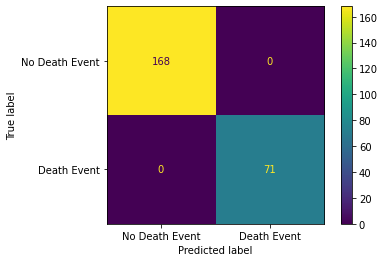

In [14]:
from sklearn.metrics import ConfusionMatrixDisplay  # Recommended method in sklearn 1.0

pipe_rf.fit(X_train, y_train)
cm = ConfusionMatrixDisplay.from_estimator(
    pipe_rf, X_train, y_train, values_format="d", display_labels=["No Death Event", "Death Event"]
)



Visualizing the confusion  matrix of test data :

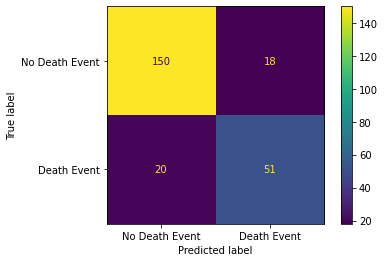

In [15]:
# Confusion Matrix for the test set

pipe_rf.fit(X_test, y_test)
cm = ConfusionMatrixDisplay.from_estimator(
    pipe_rf, X_train, y_train, values_format="d", display_labels=["No Death Event", "Death Event"]
)

Test the model :

In [16]:
# Table of Metrics for train set

PR_curve_df = pd.DataFrame(precision_recall_curve(y_train, rand_search_rf.predict_proba(X_train)[:,1],), index=["precision","recall","threshold"]).T
PR_curve_df['F1 Score'] =  2 * (PR_curve_df['precision'] * PR_curve_df['recall'])/(PR_curve_df['precision'] + PR_curve_df['recall'])
PR_curve_df

,precision,recall,threshold,F1 Score
0,1.0,1.000000,0.665000,1.000000
1,1.0,0.985915,0.670000,0.992908
2,1.0,0.971831,0.675000,0.985714
3,1.0,0.943662,0.678855,0.971014
4,1.0,0.929577,0.682500,0.963504
5,1.0,0.915493,0.685000,0.955882
6,1.0,0.901408,0.690000,0.948148
7,1.0,0.887324,0.700000,0.940299
8,1.0,0.873239,0.705000,0.932331
9,1.0,0.859155,0.710000,0.924242


In [17]:
ap_forest = average_precision_score(y_test, pipe_rf.predict_proba(X_test)[:, 1])
print("Average precision for the  Random Forest Classifier:")
print(ap_forest)

Average precision for the  Random Forest Classifier:
1.0


In [18]:
# Threshold to get best F1 score
maximum_f1_df = PR_curve_df.iloc[PR_curve_df["F1 Score"].idxmax()].to_frame().T
best_thres = maximum_f1_df['threshold'].iloc[0]
maximum_f1_df

,precision,recall,threshold,F1 Score
0,1.0,1.0,0.665,1.0


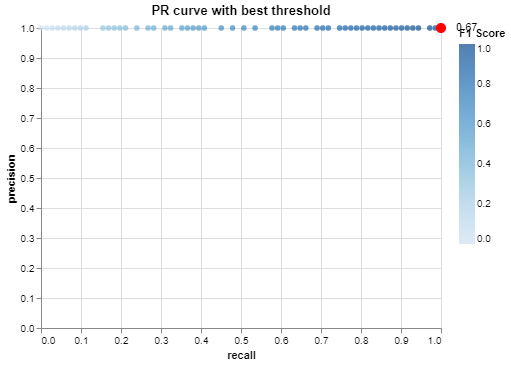

In [19]:
# PR curve with best threshold

PR_curve = alt.Chart(PR_curve_df).mark_circle().encode(
    x="recall",
    y="precision",
    color="F1 Score"
)
max_f1_point = alt.Chart(maximum_f1_df, 
                         title = 'PR curve with best threshold',).mark_circle(
    color="red", size=100, opacity=1).encode(
    x="recall",
    y="precision"
)

text = max_f1_point.mark_text(
    align='left',
    baseline='middle',
    dx=15).encode(text= alt.Text("threshold", format = ".2f"))

PR_curve_plot = PR_curve + max_f1_point + text
PR_curve_plot

In [20]:
# Evaluate Model with test data set with best_thres
y_pred_train_thres = rand_search_rf.predict_proba(X_train)[:, 1] > best_thres
y_pred_thres = rand_search_rf.predict_proba(X_test)[:, 1] > best_thres

In [21]:
# Table of Metrics for positive class with best_thres
model_perf_thres_df = pd.DataFrame(
    {
        "Accuracy": [accuracy_score(y_train, y_pred_train_thres), accuracy_score(y_test, y_pred_thres)],
        "Precision": [precision_score(y_train, y_pred_train_thres), precision_score(y_test, y_pred_thres)],
        "Recall": [recall_score(y_train, y_pred_train_thres), recall_score(y_test, y_pred_thres)],
        "F1 Score": [f1_score(y_train, y_pred_train_thres), f1_score(y_test, y_pred_thres)]
    },
    index=["Training data with best threshold", "Test Data with best threshold"])

In [22]:
best_threshold_df = pd.concat([performance_df, model_perf_thres_df])
best_threshold_df

,Accuracy,Precision,Recall,F1 Score
Training Data Set,1.000000,1.00,1.000000,1.000000
Test Data Set,0.816667,0.85,0.680000,0.755556
Training data with best threshold,0.995816,1.00,0.985915,0.992908
Test Data with best threshold,0.733333,1.00,0.360000,0.529412


#### ROC Curve

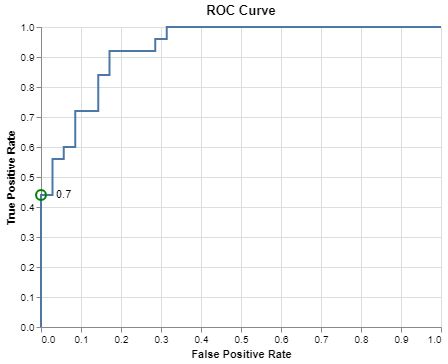

In [23]:
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, rand_search_rf.predict_proba(X_test)[:, 1])

roc_df = pd.DataFrame()
roc_df['fpr'] = false_positive_rate
roc_df['tpr'] = true_positive_rate
roc_df['thresholds'] = thresholds

pt_roc_index = (roc_df['thresholds'] - best_thres).abs().argmin()

roc_curves = alt.Chart(roc_df, title = "ROC Curve").mark_line().encode(
        alt.X('fpr', title="False Positive Rate"),
        alt.Y('tpr', title="True Positive Rate"))

roc_max_f1_point = alt.Chart(pd.DataFrame(roc_df.iloc[pt_roc_index]).T, 
                         ).mark_point(
    color="green", size=100, opacity=1).encode(
    x="fpr",
    y="tpr"
)

roc_text = roc_max_f1_point.mark_text(
    align='left',
    baseline='middle',
    dx=15).encode(text= alt.Text("thresholds:Q", format = ".1f"))

roc_curve_plot = roc_curves + roc_max_f1_point + roc_text
roc_curve_plot

#### ROC_AUC and Average Precision score

In [24]:
ap_forest = average_precision_score(y_test, rand_search_rf.predict_proba(X_test)[:, 1])
roc_forest = roc_auc_score(y_test, rand_search_rf.predict_proba(X_test)[:, 1])

test_model_perf_df = pd.DataFrame({
    "Accuracy" : model_perf_thres_df.loc["Test Data with best threshold"]["Accuracy"],
    "Precision" : model_perf_thres_df.loc["Test Data with best threshold"]["Precision"],
    "Recall" : model_perf_thres_df.loc["Test Data with best threshold"]["Recall"],
    "F1 Score" : model_perf_thres_df.loc["Test Data with best threshold"]["F1 Score"],
    "Average Precision Score" : ap_forest,
    "AUC Score" : roc_forest},
    index = ["Test Data Metrics"]).T
test_model_perf_df

,Test Data Metrics
Accuracy,0.733333
Precision,1.000000
Recall,0.360000
F1 Score,0.529412
Average Precision Score,0.904111
AUC Score,0.929143


#### Feature importance

In [25]:
importances = pipe_rf["randomforestclassifier"].feature_importances_
importances

array([0.13307898, 0.07873137, 0.10118697, 0.08757637, 0.19101967,
       0.0875399 , 0.21217084, 0.01369166, 0.01675724, 0.0174539 ,
       0.00991847, 0.01323486, 0.01321672, 0.01485861, 0.00956444])

<AxesSubplot:>

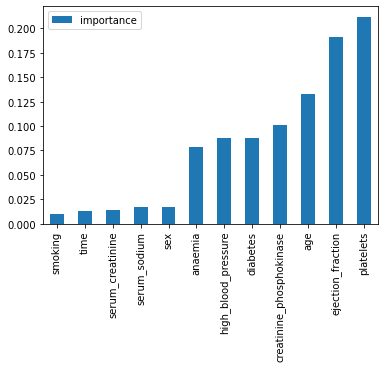

In [26]:
%matplotlib inline
feats = {} # a dict to hold feature_name: feature_importance
for feature, importance in zip(X_train.columns, pipe_rf["randomforestclassifier"].feature_importances_):
    feats[feature] = importance #add the name/value pair 

importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'importance'})
importances.sort_values(by='importance').plot(kind='bar', rot=90)